In [ ]:
pip install requests pydub librosa numpy pandas


In [ ]:
import os
import zipfile
import gdown

test_url = "https://drive.google.com/uc?id=1SCMqoDBqrBC_GmxWDnRHMXh4tBYdyZ1E"
train_url = "https://drive.google.com/uc?id=1gTa_ru71utoFjAGilLZvd96VYiypUyKj"

os.makedirs('/content/data', exist_ok=True)

def download_and_unzip(url, output_path, file_name):
    file_path = os.path.join(output_path, file_name)

    gdown.download(url, file_path, quiet=False)

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

    os.remove(file_path)

output_directory = '/content/data'
download_and_unzip(test_url, output_directory, "test.zip")
download_and_unzip(train_url, output_directory, "train.zip")

print("Files downloaded and unzipped successfully!")


Downloading...
From (original): https://drive.google.com/uc?id=1SCMqoDBqrBC_GmxWDnRHMXh4tBYdyZ1E
From (redirected): https://drive.google.com/uc?id=1SCMqoDBqrBC_GmxWDnRHMXh4tBYdyZ1E&confirm=t&uuid=453479ac-b10d-4005-be79-8b814d9d8651
To: /content/data/test.zip
100%|██████████| 386M/386M [00:08<00:00, 43.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1gTa_ru71utoFjAGilLZvd96VYiypUyKj
From (redirected): https://drive.google.com/uc?id=1gTa_ru71utoFjAGilLZvd96VYiypUyKj&confirm=t&uuid=f6c41309-a85b-476f-a897-34c70560557e
To: /content/data/train.zip
  3%|▎         | 50.9M/1.53G [00:00<00:25, 57.6MB/s]

KeyboardInterrupt: 

In [ ]:
import os
import shutil

genres = ["rock", "pop", "jazz", "electronic", "classical", "hiphop", "metal", "blues"]

train_dir = '/content/data/train'
test_dir = '/content/data/test'


def clean_directory(directory, allowed_genres):
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path) and folder_name not in allowed_genres:
            print(f"Deleting folder: {folder_path}")
            shutil.rmtree(folder_path)

clean_directory(train_dir, genres)
clean_directory(test_dir, genres)

print("Cleanup completed!")


Deleting folder: /content/data/train/reggae
Deleting folder: /content/data/train/disco
Deleting folder: /content/data/train/country
Deleting folder: /content/data/test/reggae
Deleting folder: /content/data/test/disco
Deleting folder: /content/data/test/country
Cleanup completed!


In [ ]:
import librosa
import numpy as np
import pandas as pd
import os

def extract_features(file_path, genre, data_type):
    y_full, sr_full = librosa.load(file_path)
    file_duration = librosa.get_duration(y=y_full, sr=sr_full)

    if file_duration >= 30:
        duration = 30
    else:
        duration = 10

    y, sr = librosa.load(file_path, duration=duration)

    features = {
        'data_type': data_type,
        'genre': genre,
        'length': duration,
        'chroma_stft_mean': np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        'chroma_stft_var': np.var(librosa.feature.chroma_stft(y=y, sr=sr)),
        'rms_mean': np.mean(librosa.feature.rms(y=y)),
        'rms_var': np.var(librosa.feature.rms(y=y)),
        'spectral_centroid_mean': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_centroid_var': np.var(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_bandwidth_mean': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'spectral_bandwidth_var': np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'rolloff_mean': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        'rolloff_var': np.var(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        'zero_crossing_rate_mean': np.mean(librosa.feature.zero_crossing_rate(y=y)),
        'zero_crossing_rate_var': np.var(librosa.feature.zero_crossing_rate(y=y)),
        'harmony_mean': np.mean(librosa.effects.harmonic(y=y)),
        'harmony_var': np.var(librosa.effects.harmonic(y=y)),
        'percussive_mean': np.mean(librosa.effects.percussive(y=y)),
        'percussive_var': np.var(librosa.effects.percussive(y=y)),
    }

    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1])
        features[f'mfcc{i}_var'] = np.var(mfccs[i-1])

    return features

def process_directory(directory_path, data_type):
    if not os.path.exists(directory_path):
        raise FileNotFoundError(f"Directory not found: {directory_path}")

    data = []
    for genre in os.listdir(directory_path):
        genre_path = os.path.join(directory_path, genre)
        if os.path.isdir(genre_path):  # Ensure it is a folder
            print(f"Processing genre: {genre}")
            for filename in os.listdir(genre_path):
                if filename.lower().endswith(('.mp3', '.wav')):
                    file_path = os.path.join(genre_path, filename)
                    print(f"Processing: {filename}")
                    try:
                        features = extract_features(file_path, genre, data_type)
                        data.append(features)
                    except Exception as e:
                        print(f"Error processing {filename}: {str(e)}")
                        continue

    if not data:
        raise ValueError(f"No valid audio files found in {directory_path}")

    return pd.DataFrame(data)

def main():
    train_dir = '/content/data/train'

    try:
        print("\nProcessing test data...")
        test_features = process_directory(test_dir, data_type="test")
        all_features = pd.concat([train_features, test_features], ignore_index=True)
        output_file = 'music_features.csv'
        all_features.to_csv(output_file, index=False)
        print(f"\nFeature extraction completed. Saved to {output_file}")
        print(f"Total samples processed: {len(all_features)}")
        print(f"Features extracted per sample: {len(all_features.columns)}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Processing training data...
Processing genre: pop
Processing: pop.00055.wav
Processing: RED_LIGHT.wav
Processing: Chica_Acida.wav
Processing: Oriental_Beauty.wav
Processing: For_a_Song.wav
Processing: pop.00071.wav
Processing: pop.00058.wav
Processing: My_Style.wav
Processing: pop.00082.wav
Processing: pop.00046.wav
Processing: Sol_y_Luna.wav
Processing: Highway_to_the_wild.wav
Processing: pop.00020.wav
Processing: pop.00012.wav
Processing: Mes_lents_colis.wav
Processing: pop.00019.wav
Processing: Impulso_de_un_Aro.wav
Processing: pop.00034.wav
Processing: pop.00045.wav
Processing: pop.00036.wav
Processing: pop.00005.wav
Processing: pop.00026.wav
Processing: pop.00067.wav
Processing: Daily_Dance.wav
Processing: pop.00087.wav
Processing: Positive_Emotions.wav
Processing: pop.00073.wav
Processing: pop.00061.wav
Processing: pop.00035.wav
Processing: pop.00086.wav
Processing: Bright_Future_(loop).wav
Processing: pop.00010.wav
Processing: pop.00041.wav
Processing: pop.00051.wav
Processing: 

<ipython-input-4-a6e8d073c28f>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y_full, sr_full = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing jazz.00054.wav: 
Processing: jazz.00016.wav
Processing: jazz.00077.wav
Processing: jazz.00038.wav
Processing: jazz.00001.wav
Processing: jazz.00073.wav
Processing: Notturno.wav
Processing: Sweet_and_Salt.wav
Processing: 05_-_Blue_Night_Dance.wav
Processing: jazz.00049.wav
Processing: jazz.00044.wav
Processing: Cafe_Bahia.wav
Processing: jazz.00063.wav
Processing: jazz.00040.wav
Processing: Ground_Cayenne.wav
Processing: sweet_tania.wav
Processing: jazz.00070.wav
Processing: jazz.00055.wav
Processing: Bad_Call.wav
Processing: jazz.00019.wav
Processing: jazz.00037.wav
Processing: An_Obsessive_Love.wav
Processing: Colonially_French_Kiss_.wav
Processing: jazz.00093.wav
Processing genre: blues
Processing: blues.00081.wav
Processing: Modigger.wav
Processing: Getting_Going.wav
Processing: blues.00025.wav
Processing: The_sexy_blues_strikes_again.wav
Processing: Burning_flame.wav
Processing: blues.00032.wav
Processing: blues.00057.wav
Processing: blues.00093.wav
Processing: blu

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time


In [ ]:
def analyze_feature_importance(features, target):
    """
    Analyze feature importance using multiple methods
    """
    correlation_matrix = features.corr()

    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(features, target)
    feature_scores = pd.DataFrame({
        'Feature': features.columns,
        'F_Score': selector.scores_,
        'P_value': selector.pvalues_
    })
    feature_scores = feature_scores.sort_values('F_Score', ascending=False)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(features, target)
    rf_importance = pd.DataFrame({
        'Feature': features.columns,
        'Importance': rf.feature_importances_
    })
    rf_importance = rf_importance.sort_values('Importance', ascending=False)

    return correlation_matrix, feature_scores, rf_importance

def select_features(features, target, n_features=20):
    """
    Select the best features using multiple methods
    """
    anova_selector = SelectKBest(score_func=f_classif, k=n_features)
    anova_selected = anova_selector.fit_transform(features, target)
    selected_features_anova = features.columns[anova_selector.get_support()].tolist()

    rf_selector = SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        max_features=n_features
    )
    rf_selector.fit(features, target)
    selected_features_rf = features.columns[rf_selector.get_support()].tolist()

    pca = PCA(n_components=0.95)
    pca_result = pca.fit_transform(StandardScaler().fit_transform(features))

    return {
        'anova_features': selected_features_anova,
        'rf_features': selected_features_rf,
        'n_pca_components': pca_result.shape[1],
        'pca_explained_variance': pca.explained_variance_ratio_
    }

def plot_feature_analysis(correlation_matrix, feature_scores, rf_importance):
    """
    Create visualizations for feature analysis
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_scores.head(20), x='F_Score', y='Feature')
    plt.title('Top 20 Features by F-Score')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=rf_importance.head(20), x='Importance', y='Feature')
    plt.title('Top 20 Features by Random Forest Importance')
    plt.tight_layout()
    plt.show()


Original dataset shape: (910, 60)
Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.

Cleaned features shape: (910, 57)
Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.

Top 10 Most Important Features by ANOVA F-test:
chroma_stft_mean: F-Score = 260.16
chroma_stft_var: F-Score = 96.98
rms_mean: F-Score = 118.04
rms_var: F-Score = 106.56
spectral_centroid_mean: F-Score = 122.02
spectral_centroid_var: F-Score = 136.28
spectral_bandwidth_mean: F-Score = 158.89
rolloff_mean: F-Score = 146.63
percussive_var: F-Score = 110.29
mfcc1_mean: F-Score = 260.12

Top 10 Most Important Features by Random Forest:
chroma_stft_mean: Importance = 0.0639
chroma_stft_var: Importance = 0.0326
rms_mean: Importance = 0.0315
rms_var: Importance = 0.0269
spectral_centroid_var: Importance = 0.0365
spectral_bandwidth_mean: Importance = 0.0288
rolloff_mean: Importance = 0.0276
rolloff_var: Importance = 0.0319
percussive

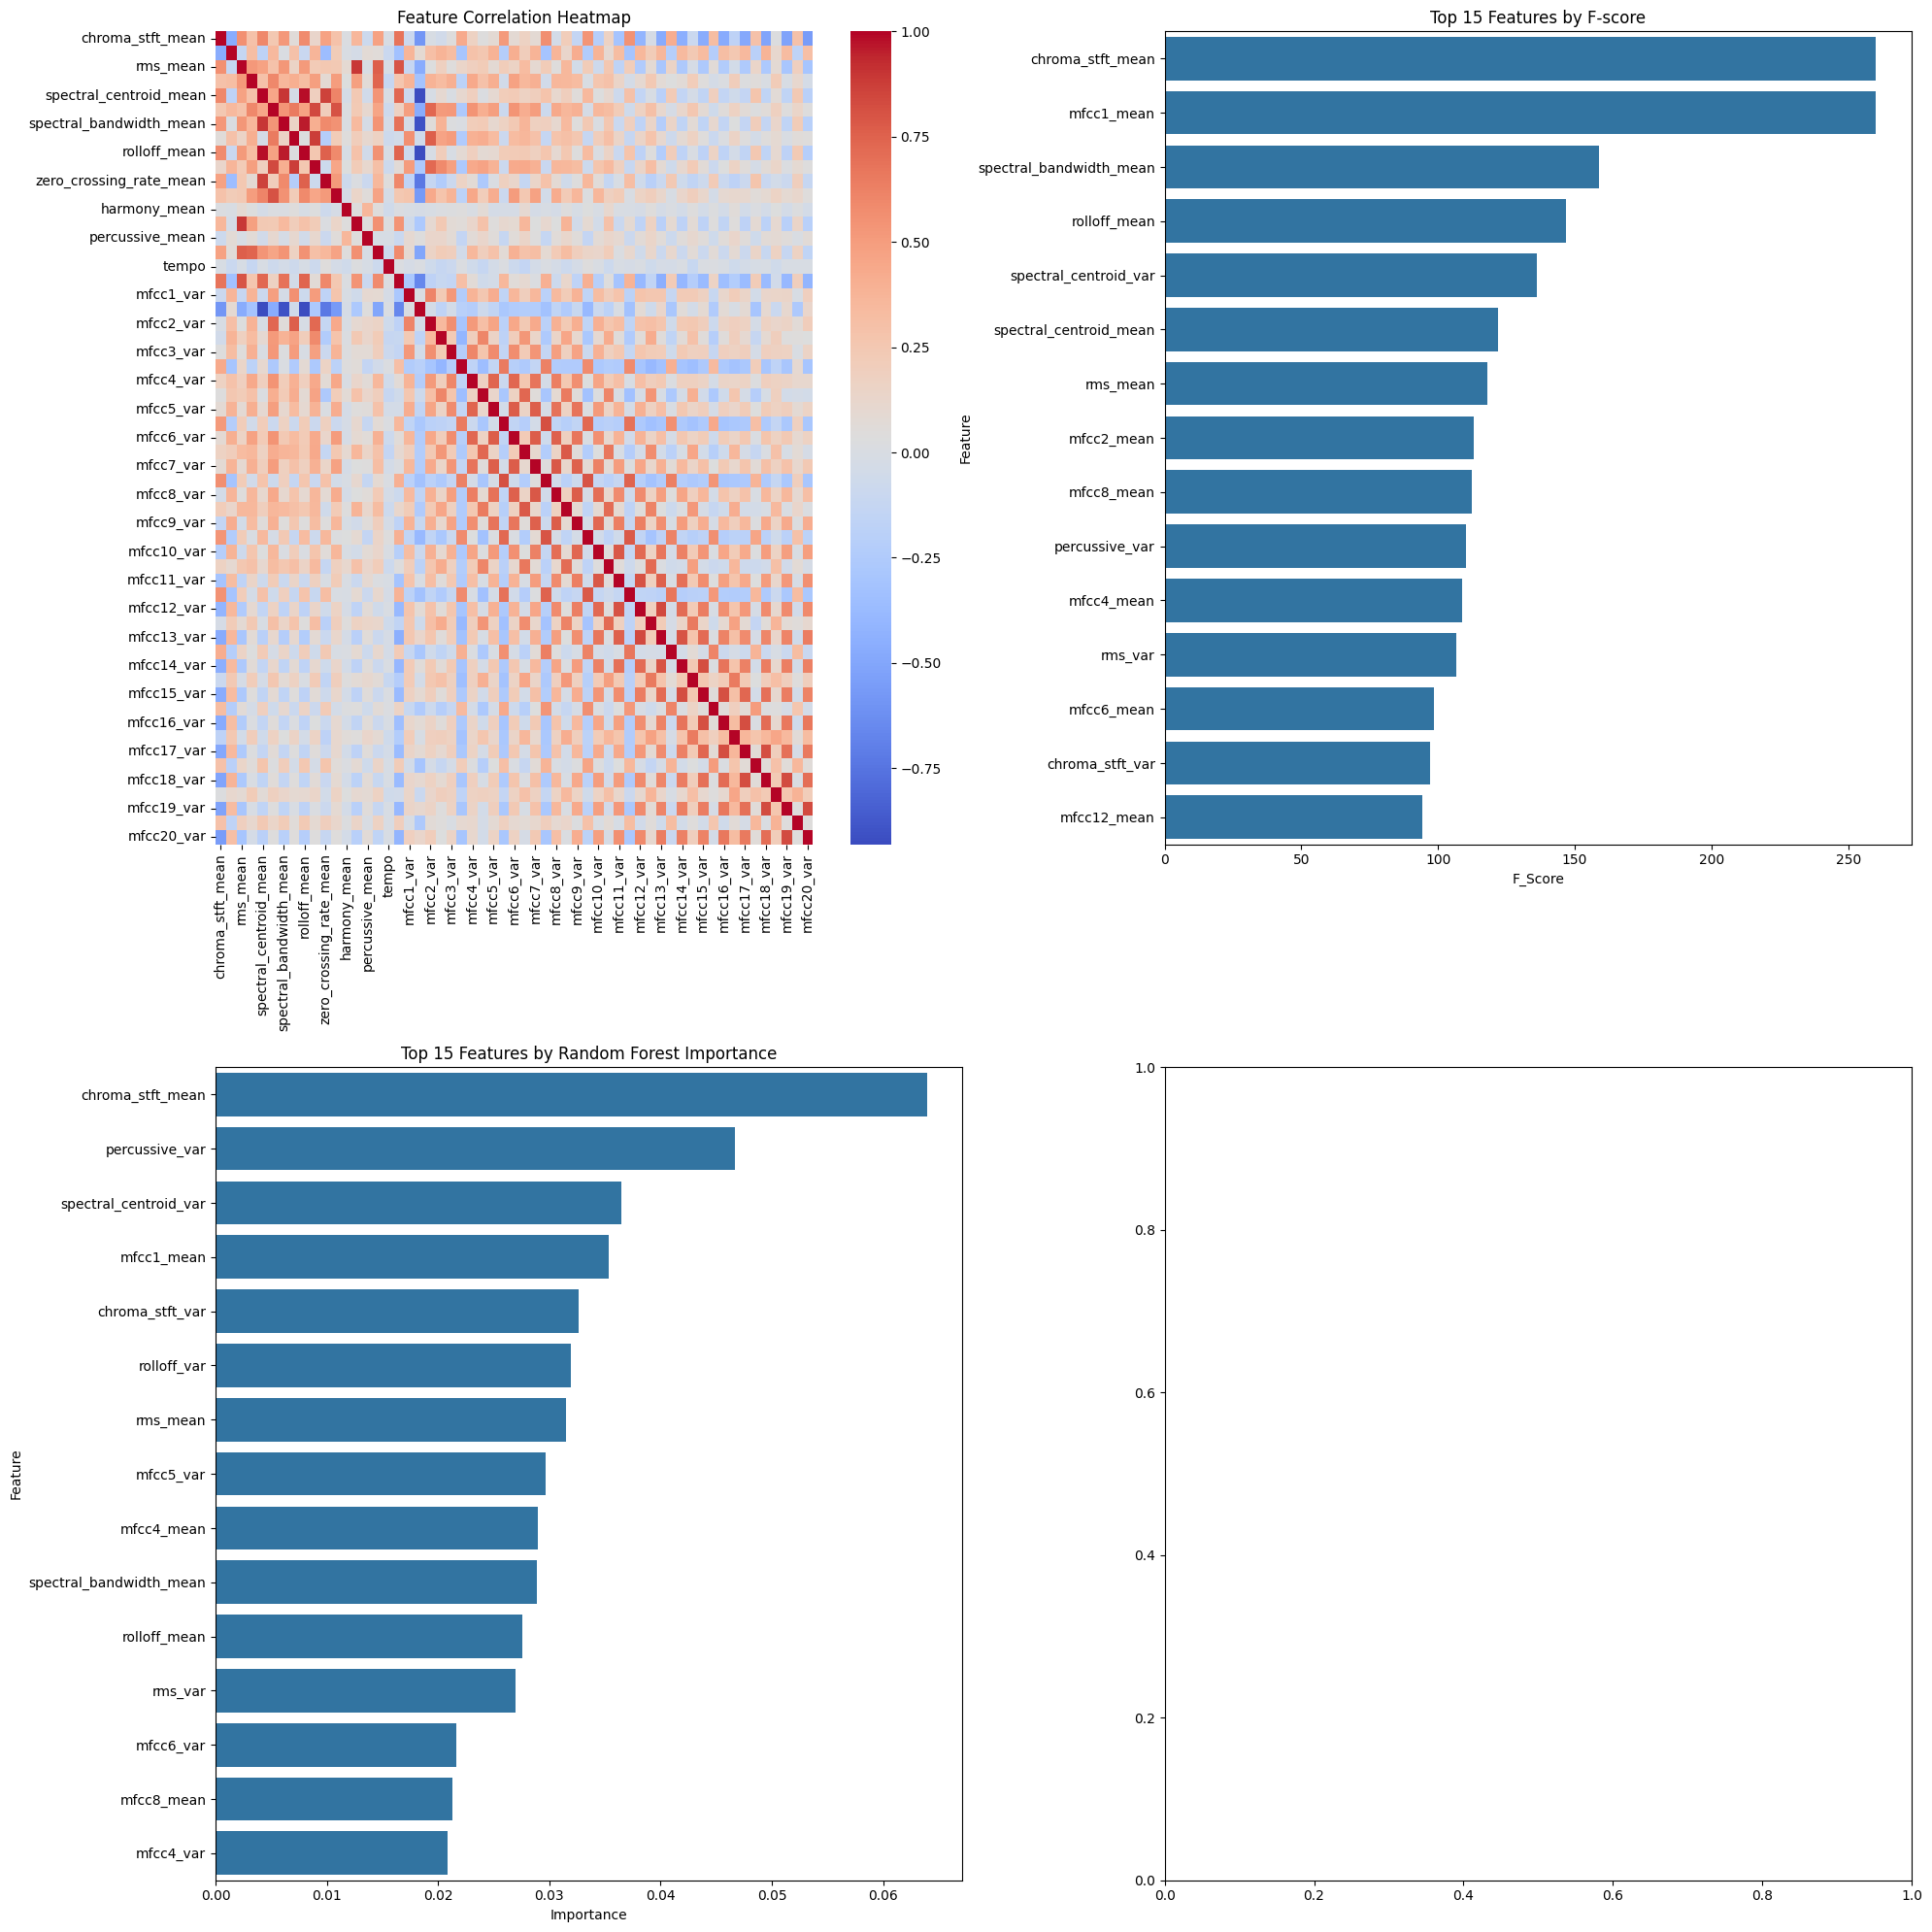

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/music_features.csv'
df = pd.read_csv(file_path)
print("Original dataset shape:", df.shape)

def clean_numeric_columns(df):
    """
    Clean numeric columns by removing square brackets and converting to float.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            try:
                df[column] = df[column].str.replace(r'[\[\]]', '', regex=True).astype(float)
            except ValueError:
                print(f"Could not convert column {column}. Keeping as is.")
    return df

def prepare_features(df):
    """
    Prepare features and target for model training.
    Clean and align all necessary columns.
    """
    df = clean_numeric_columns(df)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    df = df[df['genre'] != 'blues'].reset_index(drop=True)

    features = df.drop(['data_type', 'genre', 'length'], axis=1)
    target = df['genre']

    return features, target, df['data_type']

def prepare_data():
    """
    Prepare data for training and testing.
    Splits data into train/test sets and applies standardization.
    """
    data = pd.read_csv('/content/music_features.csv')

    features, target, data_type = prepare_features(data)

    le = LabelEncoder()
    target = le.fit_transform(target)

    train_mask = data_type == 'train'
    test_mask = data_type == 'test'

    X_train = features[train_mask].values
    y_train = target[train_mask]

    X_test = features[test_mask].values
    y_test = target[test_mask]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, le


def analyze_feature_importance(features, target):
    """Analyze feature importance using multiple methods"""
    features = features.astype(float)

    correlation_matrix = features.corr()

    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(features, target)
    feature_scores = pd.DataFrame({
        'Feature': features.columns,
        'F_Score': selector.scores_
    }).sort_values('F_Score', ascending=False)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(features, target)
    rf_importance = pd.DataFrame({
        'Feature': features.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    return correlation_matrix, feature_scores, rf_importance

def plot_feature_analysis(correlation_matrix, feature_scores, rf_importance):
    """Create visualizations for feature analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    sns.heatmap(correlation_matrix, ax=axes[0,0], cmap='coolwarm')
    axes[0,0].set_title('Feature Correlation Heatmap')

    sns.barplot(data=feature_scores.head(15), x='F_Score', y='Feature', ax=axes[0,1])
    axes[0,1].set_title('Top 15 Features by F-score')

    sns.barplot(data=rf_importance.head(15), x='Importance', y='Feature', ax=axes[1,0])
    axes[1,0].set_title('Top 15 Features by Random Forest Importance')

    plt.tight_layout()
    return fig

def select_features(features, target):
    """Select the best features using multiple methods"""
    features = features.astype(float)

    anova_selector = SelectKBest(score_func=f_classif, k=15)
    anova_selector.fit(features, target)
    anova_features = features.columns[anova_selector.get_support()].tolist()

    rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
    rf_selector.fit(features, target)
    rf_features = features.columns[rf_selector.get_support()].tolist()

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=0.95)
    pca.fit(scaled_features)

    return {
        'anova_features': anova_features,
        'rf_features': rf_features,
        'n_pca_components': len(pca.explained_variance_ratio_),
        'pca_explained_variance': pca.explained_variance_ratio_
    }

features, target, data_type = prepare_features(df)
print("\nCleaned features shape:", features.shape)
X_train, X_test, y_train, y_test, le = prepare_data()

correlation_matrix, feature_scores, rf_importance = analyze_feature_importance(features, target)

plot_feature_analysis(correlation_matrix, feature_scores, rf_importance)

selected_features = select_features(features, target)

print("\nTop 10 Most Important Features by ANOVA F-test:")
for feature in selected_features['anova_features'][:10]:
    score = feature_scores[feature_scores['Feature'] == feature]['F_Score'].values[0]
    print(f"{feature}: F-Score = {score:.2f}")

print("\nTop 10 Most Important Features by Random Forest:")
for feature in selected_features['rf_features'][:10]:
    importance = rf_importance[rf_importance['Feature'] == feature]['Importance'].values[0]
    print(f"{feature}: Importance = {importance:.4f}")

print(f"\nNumber of PCA components needed to preserve 95% variance: {selected_features['n_pca_components']}")
print("\nCumulative explained variance ratio by PCA components:")
cumulative_variance = np.cumsum(selected_features['pca_explained_variance'])
for i, variance in enumerate(cumulative_variance[:10], 1):
    print(f"Component {i}: {variance:.4f}")



In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import pandas as pd

def compute_intra_inter_class_similarity(features, labels):
    """
    Compute intra-class and inter-class similarities using Euclidean distance.

    Parameters:
    - features (ndarray): Feature matrix (rows = samples, columns = features)
    - labels (ndarray): Corresponding class labels for each sample

    Returns:
    - intra_class_similarities (dict): Average similarity within each class
    - inter_class_similarities (dict): Average similarity between each pair of classes
    """
    unique_classes = np.unique(labels)
    intra_class_similarities = {}
    inter_class_similarities = {}

    for cls in unique_classes:
        class_features = features[labels == cls]
        if len(class_features) > 1:
            distances = euclidean_distances(class_features)
            intra_class_similarities[cls] = np.mean(distances[np.triu_indices_from(distances, k=1)])
        else:
            intra_class_similarities[cls] = None

    for i, cls1 in enumerate(unique_classes):
        for cls2 in unique_classes[i + 1:]:
            features_cls1 = features[labels == cls1]
            features_cls2 = features[labels == cls2]
            distances = euclidean_distances(features_cls1, features_cls2)
            inter_class_similarities[f"{cls1} vs {cls2}"] = np.mean(distances)

    return intra_class_similarities, inter_class_similarities

def prepare_and_compute_similarity():
    data = pd.read_csv('music_features.csv')

    features, target, _ = prepare_features(data)
    features = features.values
    labels = target.values

    intra_class_sim, inter_class_sim = compute_intra_inter_class_similarity(features, labels)

    print("Intra-Class Similarities:")
    for cls, sim in intra_class_sim.items():
        print(f"Class {cls}: {sim}")

    print("\nInter-Class Similarities:")
    for pair, sim in inter_class_sim.items():
        print(f"{pair}: {sim}")

    return intra_class_sim, inter_class_sim

intra_class_similarities, inter_class_similarities = prepare_and_compute_similarity()


Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.
Intra-Class Similarities:
Class classical: 564613.7922741032
Class hiphop: 2791285.8326891423
Class jazz: 1818487.0568510746
Class metal: 686659.6154672282
Class pop: 1987818.7238392243
Class rock: 1479262.4535281511

Inter-Class Similarities:
classical vs hiphop: 3208968.7099314574
classical vs jazz: 1718715.740912264
classical vs metal: 724186.7554515696
classical vs pop: 2989528.4315031874
classical vs rock: 1551230.3136369784
hiphop vs jazz: 2692978.394351143
hiphop vs metal: 2890149.057364011
hiphop vs pop: 2431196.63035674
hiphop vs rock: 2576002.9497071803
jazz vs metal: 1500165.5074221129
jazz vs pop: 2349819.66778672
jazz vs rock: 1650238.0958064178
metal vs pop: 2632922.5134919304
metal vs rock: 1314040.0847514372
pop vs rock: 2219985.113145036


Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.

Cluster Composition Analysis:
----------------------------------------

Cluster 1 composition:
Class 0: 7 samples
Class 1: 1 samples
Class 2: 11 samples
Class 4: 8 samples

Cluster 2 composition:
Class 0: 50 samples
Class 1: 6 samples
Class 2: 45 samples
Class 3: 7 samples
Class 4: 24 samples
Class 5: 24 samples

Cluster 3 composition:
Class 0: 1 samples
Class 1: 44 samples
Class 2: 2 samples
Class 3: 7 samples
Class 4: 41 samples
Class 5: 5 samples

Cluster 4 composition:
Class 1: 35 samples
Class 2: 1 samples
Class 3: 77 samples
Class 4: 6 samples
Class 5: 14 samples

Cluster 5 composition:
Class 0: 55 samples
Class 1: 4 samples
Class 2: 35 samples
Class 4: 12 samples
Class 5: 3 samples

Cluster 6 composition:
Class 0: 3 samples
Class 1: 36 samples
Class 2: 24 samples
Class 3: 33 samples
Class 4: 33 samples
Class 5: 74 samples


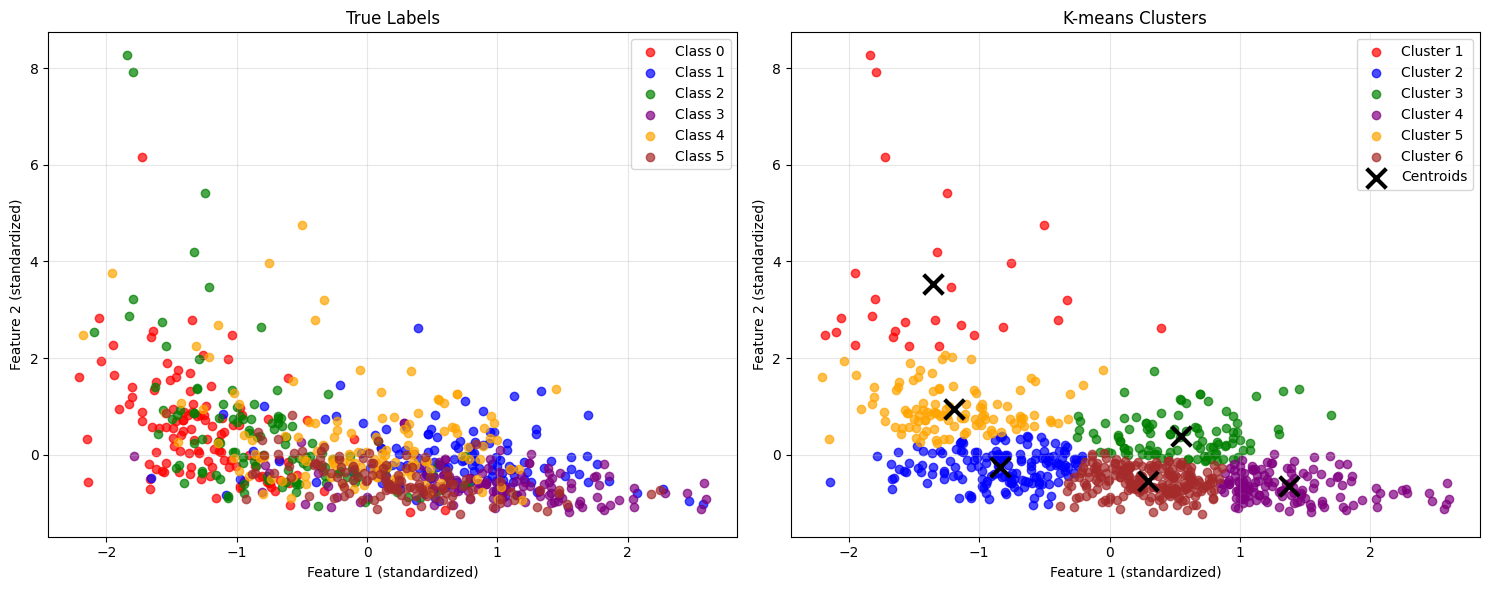

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def kmeans(X, n_clusters=6, max_iters=100):
    np.random.seed(42)
    n_samples = X.shape[0]
    random_indices = np.random.choice(n_samples, n_clusters, replace=False)
    centroids = X[random_indices]

    for iteration in range(max_iters):
        distances = np.zeros((n_samples, n_clusters))
        for i in range(n_clusters):
            distances[:, i] = np.sqrt(np.sum((X - centroids[i])**2, axis=1))
        labels = np.argmin(distances, axis=1)
        new_centroids = np.zeros_like(centroids)
        for i in range(n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[i] = centroids[i]

        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

X_train, X_val, y_train, y_val, le = prepare_data()

selected_features = [0, 48]
X_selected = X_train[:, selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

centroids, cluster_labels = kmeans(X_scaled, n_clusters=6)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
for i in range(6):
    mask = y_train == i
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                c=colors[i], label=f'Class {i}', alpha=0.7)
plt.title('True Labels')
plt.xlabel('Feature 1 (standardized)')
plt.ylabel('Feature 2 (standardized)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for i in range(6):
    mask = cluster_labels == i
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1],
                c=colors[i], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='black', marker='x', s=200, linewidth=3,
            label='Centroids')
plt.title('K-means Clusters')
plt.xlabel('Feature 1 (standardized)')
plt.ylabel('Feature 2 (standardized)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

print("\nCluster Composition Analysis:")
print("-" * 40)
for i in range(6):
    cluster_mask = cluster_labels == i
    print(f"\nCluster {i+1} composition:")
    for j in range(6):
        class_count = np.sum((y_train == j) & cluster_mask)
        if class_count > 0:
            print(f"Class {j}: {class_count} samples")

plt.show()

Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.
Iteration 0
Train Loss: 0.6931, Accuracy: 0.5577
Val Loss: 0.6882, Accuracy: 0.5714
----------------------------------------
Iteration 100
Train Loss: 0.5069, Accuracy: 0.6154
Val Loss: 0.5117, Accuracy: 0.5989
----------------------------------------
Iteration 200
Train Loss: 0.4343, Accuracy: 0.6552
Val Loss: 0.4421, Accuracy: 0.6538
----------------------------------------
Iteration 300
Train Loss: 0.3870, Accuracy: 0.6717
Val Loss: 0.3965, Accuracy: 0.6758
----------------------------------------
Iteration 400
Train Loss: 0.3538, Accuracy: 0.6786
Val Loss: 0.3646, Accuracy: 0.6813
----------------------------------------
Iteration 500
Train Loss: 0.3295, Accuracy: 0.6909
Val Loss: 0.3413, Accuracy: 0.6978
----------------------------------------
Iteration 600
Train Loss: 0.3110, Accuracy: 0.7060
Val Loss: 0.3237, Accuracy: 0.6978
----------------------------------------
Iteration 700
T

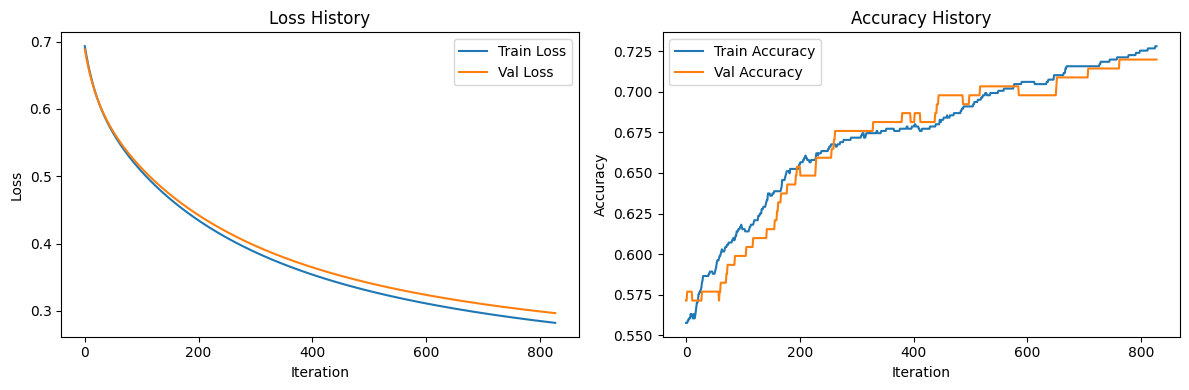

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

class LogisticRegressionAnalyzer:
    def __init__(self, learning_rate=0.01, max_iterations=1000, lambda_reg=0.1,
                 tolerance=1e-4, min_change_count=3):
        self.lr = learning_rate
        self.max_iterations = max_iterations
        self.lambda_reg = lambda_reg
        self.tolerance = tolerance
        self.min_change_count = min_change_count
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def to_onehot(self, y):
        return pd.get_dummies(y).values

    def compute_loss(self, X, y_true, predictions=None):
        y_onehot = self.to_onehot(y_true)
        if predictions is None:
            predictions = self.predict_proba(X)

        m = X.shape[0]
        cross_entropy = -np.mean(
            y_onehot * np.log(predictions + 1e-15) +
            (1 - y_onehot) * np.log(1 - predictions + 1e-15)
        )
        l2_reg = (self.lambda_reg / (2 * m)) * np.sum(self.weights ** 2)
        return cross_entropy + l2_reg

    def compute_metrics(self, X, y_true):
        predictions = self.predict_proba(X)
        y_pred = self.predict(X)
        y_onehot = self.to_onehot(y_true)
        accuracy = np.mean(y_pred == y_true)

        n_classes = predictions.shape[1]
        metrics = {
            'accuracy': accuracy,
            'per_class': {}
        }

        for c in range(n_classes):
            y_true_binary = (y_true == c).astype(int)
            y_pred_binary = (y_pred == c).astype(int)
            pred_proba = predictions[:, c]
            fpr, tpr, _ = roc_curve(y_true_binary, pred_proba)
            roc_auc = auc(fpr, tpr)
            precision, recall, _ = precision_recall_curve(y_true_binary, pred_proba)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-15)

            metrics['per_class'][c] = {
                'auroc': roc_auc,
                'precision': np.mean(precision),
                'recall': np.mean(recall),
                'f1': np.mean(f1)
            }

        metrics['avg_auroc'] = np.mean([m['auroc'] for m in metrics['per_class'].values()])
        metrics['avg_precision'] = np.mean([m['precision'] for m in metrics['per_class'].values()])
        metrics['avg_recall'] = np.mean([m['recall'] for m in metrics['per_class'].values()])
        metrics['avg_f1'] = np.mean([m['f1'] for m in metrics['per_class'].values()])

        return metrics

    def fit(self, X_train, y_train, X_val=None, y_val=None, verbose=True):
        self.weights = np.zeros((X_train.shape[1], len(np.unique(y_train))))
        self.bias = np.zeros(len(np.unique(y_train)))
        y_train_onehot = self.to_onehot(y_train)

        prev_loss = float('inf')
        small_change_count = 0

        for iteration in range(self.max_iterations):
            z = np.dot(X_train, self.weights) + self.bias
            train_predictions = self.sigmoid(z)
            dw = (np.dot(X_train.T, (train_predictions - y_train_onehot)) +
                  self.lambda_reg * self.weights) / X_train.shape[0]
            db = np.sum(train_predictions - y_train_onehot, axis=0) / X_train.shape[0]
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            train_loss = self.compute_loss(X_train, y_train, train_predictions)
            train_metrics = self.compute_metrics(X_train, y_train)

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_metrics['accuracy'])

            if X_val is not None and y_val is not None:
                val_predictions = self.predict_proba(X_val)
                val_loss = self.compute_loss(X_val, y_val, val_predictions)
                val_metrics = self.compute_metrics(X_val, y_val)

                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_metrics['accuracy'])
                if len(self.history['val_loss']) > 1:
                    if val_loss > self.history['val_loss'][-2] * 1.05:
                        if verbose:
                            print(f"Early stopping at iteration {iteration}: Validation loss increasing")
                        break

            loss_change = abs(prev_loss - train_loss)
            if loss_change < self.tolerance:
                small_change_count += 1
                if small_change_count >= self.min_change_count:
                    if verbose:
                        print(f"Converged at iteration {iteration}")
                    break
            else:
                small_change_count = 0

            prev_loss = train_loss

            if verbose and iteration % 100 == 0:
                print(f"Iteration {iteration}")
                print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")
                if X_val is not None and y_val is not None:
                    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
                print("----------------------------------------")

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def plot_training_history(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        if len(self.history['val_loss']) > 0:
            plt.plot(self.history['val_loss'], label='Val Loss')
        plt.title('Loss History')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Accuracy')
        if len(self.history['val_acc']) > 0:
            plt.plot(self.history['val_acc'], label='Val Accuracy')
        plt.title('Accuracy History')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()


X_train, X_test, y_train, y_test, le = prepare_data()

custom_model = LogisticRegressionAnalyzer(learning_rate=0.01, lambda_reg=0.1)
custom_start = time.time()
custom_model.fit(X_train, y_train, X_test, y_test)
custom_time = time.time() - custom_start

sklearn_model = LogisticRegression(max_iter=1000)
sklearn_start = time.time()
sklearn_model.fit(X_train, y_train)
sklearn_time = time.time() - sklearn_start

custom_metrics = custom_model.compute_metrics(X_test, y_test)
sklearn_pred = sklearn_model.predict(X_test)
sklearn_pred_proba = sklearn_model.predict_proba(X_test)

sklearn_metrics = custom_model.compute_metrics(X_test, y_test)

print("\nCustom Implementation:")
print(f"Training time: {custom_time:.4f} seconds")
print(f"Test accuracy: {custom_metrics['accuracy']:.4f}")
print(f"Average AUROC: {custom_metrics['avg_auroc']:.4f}")
print(f"Average F1: {custom_metrics['avg_f1']:.4f}")
print(f"Average Precision: {custom_metrics['avg_precision']:.4f}")
print(f"Average Recall: {custom_metrics['avg_recall']:.4f}")

print("\nScikit-learn Implementation:")
print(f"Training time: {sklearn_time:.4f} seconds")
print(f"Test accuracy: {sklearn_metrics['accuracy']:.4f}")
print(f"Average AUROC: {sklearn_metrics['avg_auroc']:.4f}")
print(f"Average F1: {sklearn_metrics['avg_f1']:.4f}")
print(f"Average Precision: {sklearn_metrics['avg_precision']:.4f}")
print(f"Average Recall: {sklearn_metrics['avg_recall']:.4f}")


custom_metrics = custom_model.compute_metrics(X_test, y_test)
sklearn_pred = sklearn_model.predict(X_test)
sklearn_metrics = custom_model.compute_metrics(X_test, y_test)

def print_detailed_metrics(metrics, model_name):
    print(f"\n{model_name} Metrics:")
    print("-" * 50)
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print("\nPer-Class Metrics:")
    print("-" * 50)
    print(f"{'Class':<10} {'AUROC':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
    print("-" * 50)

    for class_idx, class_metrics in metrics['per_class'].items():
        class_name = le.inverse_transform([class_idx])[0]
        print(f"{class_name:<10} {class_metrics['auroc']:>10.4f} {class_metrics['precision']:>10.4f} "
              f"{class_metrics['recall']:>10.4f} {class_metrics['f1']:>10.4f}")

    print("-" * 50)
    print(f"Average:   {metrics['avg_auroc']:>10.4f} {metrics['avg_precision']:>10.4f} "
          f"{metrics['avg_recall']:>10.4f} {metrics['avg_f1']:>10.4f}")
    print("\nTraining time: {:.4f} seconds".format(
        custom_time if model_name == "Custom Implementation" else sklearn_time))

# Print detailed metrics for both implementations
print_detailed_metrics(custom_metrics, "Custom Implementation")
print_detailed_metrics(sklearn_metrics, "Scikit-learn Implementation")

# Plot training history
custom_model.plot_training_history()

In [ ]:
import cvxopt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score
from cvxopt import matrix, solvers
from itertools import combinations
from sklearn.metrics import roc_auc_score, f1_score

class SVMFromScratch:

    def __init__(self, C=1.0):
        self.C = C
        self.classifiers = {}
        solvers.options['show_progress'] = False

    def _train_binary(self, X, y, target_class):
        """
        Train a binary SVM for the given target class (1 vs rest).
        """
        y_binary = np.where(y == target_class, 1, -1).reshape(-1, 1) * 1.0
        n_samples = X.shape[0]

        K = np.dot(X, X.T)
        P = matrix(np.outer(y_binary, y_binary) * K)
        q = matrix(-np.ones((n_samples, 1)))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = matrix(y_binary.reshape(1, -1))
        b = matrix(0.0)

        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solution['x']).reshape(-1)

        sv_mask = alphas > 1e-5
        sv_alphas = alphas[sv_mask]
        sv_X = X[sv_mask]
        sv_y = y_binary[sv_mask]

        w = np.sum(sv_alphas.reshape(-1, 1) * sv_y * sv_X, axis=0)
        b = np.mean(sv_y - np.dot(sv_X, w))

        return w, b

    def fit(self, X, y):
        """
        Train one-vs-all SVMs for each class.
        """
        self.classes = np.unique(y)
        for target_class in self.classes:
            print(f"Training classifier for class {target_class} vs all...")
            w, b = self._train_binary(X, y, target_class)
            self.classifiers[target_class] = {'w': w, 'b': b}

        return self

    def predict(self, X):
        """
        Predict the class for each sample using the one-vs-all strategy.
        """
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes)))

        for class_idx, clf in self.classifiers.items():
            scores[:, class_idx] = np.dot(X, clf['w']) + clf['b']

        return self.classes[np.argmax(scores, axis=1)]


def train_sklearn_svm(X_train, y_train, X_test, y_test):
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    results = {}

    scaler = StandardScaler()

    for kernel in kernels:
        print(f"\nTraining SVM with {kernel} kernel...")
        svc = SVC(kernel=kernel, C=1.0, probability=True, random_state=42)
        svc.fit(X_train, y_train)

        y_pred_train = svc.predict(X_train)
        y_pred_test = svc.predict(X_test)
        print(f"\nClassification Report for {kernel} kernel (Training):")
        print(classification_report(y_train, y_pred_train))
        print(f"\nClassification Report for {kernel} kernel (Test):")
        print(classification_report(y_test, y_pred_test))

        print("\nAUROC Scores:")
        auroc_scores = []
        for i, genre in enumerate(np.unique(y_train)):
            y_test_binary = (y_test == genre).astype(int)
            y_pred_prob = svc.predict_proba(X_test)[:, i]
            auroc = roc_auc_score(y_test_binary, y_pred_prob)
            auroc_scores.append(auroc)
            print(f"{genre}: {auroc:.3f}")
        print(f"Average AUROC for {kernel}: {np.mean(auroc_scores):.3f}")

        results[kernel] = {
            "model": svc,
            "train_report": classification_report(y_train, y_pred_train, output_dict=True),
            "test_report": classification_report(y_test, y_pred_test, output_dict=True),
            "auroc_scores": auroc_scores,
            "average_auroc": np.mean(auroc_scores),
        }

    return results

def tune_hyperparameters(X, y):
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
    }
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    svc = SVC(random_state=42)
    grid_search = GridSearchCV(
        svc,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_scaled, y)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

def print_confusion_matrix(y_true, y_pred, le):
    cm = confusion_matrix(y_true, y_pred)
    genres = le.classes_

    print("\nConfusion Matrix:")
    print("True\Pred", end='\t')
    for genre in genres:
        print(f"{genre[:7]}", end='\t')
    print("\n" + "-"*100)

    for i, row in enumerate(cm):
        print(f"{genres[i][:7]}\t", end='')
        for cell in row:
            print(f"{cell}\t", end='')
        print()


def evaluate_model(model, X_train, X_test, y_train, y_test, le):
    print("\n=== Comprehensive Model Evaluation ===")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("\n1. Classification Accuracy (ACC):")
    print(f"Training ACC: {train_acc:.3f}")
    print(f"Testing ACC: {test_acc:.3f}")

    print("\n2. Area Under ROC Curve (AUROC):")
    auroc_scores = []
    for i, genre in enumerate(le.classes_):
        train_binary = (y_train == i).astype(int)
        test_binary = (y_test == i).astype(int)

        train_pred_binary = (y_pred_train == i).astype(int)
        test_pred_binary = (y_pred_test == i).astype(int)

        score = roc_auc_score(test_binary, test_pred_binary)
        auroc_scores.append(score)
        print(f"{genre}: {score:.3f}")
    print(f"Average AUROC: {np.mean(auroc_scores):.3f}")



    print("Training:")
    print(classification_report(y_train, y_pred_train))
    print("\nTesting:")
    print(classification_report(y_test, y_pred_test))



    print("\n5. Per-Class Performance (Test Set):")
    print(classification_report(y_test, y_pred_test, target_names=le.classes_))

    print("\n6. Confusion Matrix (Test Set):")
    print_confusion_matrix(y_test, y_pred_test, le)

X_train, X_test, y_train, y_test, le = prepare_data()
print("\n=== Part A: Custom SVM Implementation ===")
print("Performance Metrics for Custom One-vs-All SVM:")
custom_svm = SVMFromScratch(C=1.0)
custom_svm.fit(X_train, y_train)
evaluate_model(custom_svm, X_train, X_test, y_train, y_test, le)

print("\n=== Part B: Scikit-learn SVMs with Different Kernels ===")
print("Performance Metrics for Different Kernels:")
kernel_results = train_sklearn_svm(X_train, y_train, X_test, y_test)

print("\n=== Part C: Hyperparameter Tuning with Cross-validation ===")
best_svm = tune_hyperparameters(X_train, y_train)
print("\nBest Model Configuration:")
print(f"Kernel: {best_svm.kernel}")
print(f"C: {best_svm.C}")
print(f"Gamma: {best_svm.gamma}")

print("\n=== Part D: Final Model Evaluation ===")
print("Performance Metrics for Best Model:")
best_metrics = evaluate_model(best_svm, X_train, X_test, y_train, y_test, le)

print("\n=== Part E: Performance and Runtime Comparison ===")

start_time = time.time()
custom_svm = SVMFromScratch(C=1.0)
custom_svm.fit(X_train, y_train)
custom_pred = custom_svm.predict(X_test)
custom_time = time.time() - start_time
custom_accuracy = accuracy_score(y_test, custom_pred)

start_time = time.time()
sklearn_svm = best_svm
sklearn_pred = sklearn_svm.predict(X_test)
sklearn_time = time.time() - start_time
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)

print("\nComparative Analysis:")
print("1. Runtime Comparison:")
print(f"Custom SVM: {custom_time:.2f} seconds")
print(f"Sklearn SVM: {sklearn_time:.2f} seconds")

print("\n2. Performance Metrics Comparison:")
print("Custom SVM:")
print(f"- Accuracy: {custom_accuracy:.4f}")
print(f"- F1-Score: {f1_score(y_test, custom_pred, average='weighted'):.4f}")

print("\nSklearn SVM:")
print(f"- Accuracy: {sklearn_accuracy:.4f}")
print(f"- F1-Score: {f1_score(y_test, sklearn_pred, average='weighted'):.4f}")

print("\n3. Discussion:")
print("- Custom vs Sklearn Implementation:")
print(f"  Speed Difference: {custom_time/sklearn_time:.1f}x longer for custom implementation")
print(f"  Accuracy Difference: {(sklearn_accuracy-custom_accuracy)*100:.1f}% higher for sklearn")


Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.

=== Part A: Custom SVM Implementation ===
Performance Metrics for Custom One-vs-All SVM:
Training classifier for class 0 vs all...
Training classifier for class 1 vs all...
Training classifier for class 2 vs all...
Training classifier for class 3 vs all...
Training classifier for class 4 vs all...
Training classifier for class 5 vs all...

=== Comprehensive Model Evaluation ===

1. Classification Accuracy (ACC):
Training ACC: 0.857
Testing ACC: 0.731

2. Area Under ROC Curve (AUROC):
classical: 0.938
hiphop: 0.829
jazz: 0.870
metal: 0.812
pop: 0.809
rock: 0.777
Average AUROC: 0.839
Training:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       116
           1       0.93      0.89      0.91       126
           2       0.84      0.86      0.85       118
           3       0.82      0.85      0.83       124
           4       0.83      0.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)
import time

X_train, X_val, y_train, y_val, le = prepare_data()

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [16, 32],
    'max_features': ['sqrt'],
    'min_samples_split': [16, 32],
    'n_estimators': [100, 200]
}

print("Performing grid search with cross-validation...")
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
start_time = time.time()
grid_search.fit(X_train, y_train)
grid_search_time = time.time() - start_time

print(f"\nGrid search completed in {grid_search_time:.2f} seconds")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

print("\nTraining final model with best parameters...")
final_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
start_time = time.time()
final_rf.fit(X_train, y_train)
train_time = time.time() - start_time

train_pred = final_rf.predict(X_train)
test_pred = final_rf.predict(X_test)
train_pred_proba = final_rf.predict_proba(X_train)[:, 1]
test_pred_proba = final_rf.predict_proba(X_test)[:, 1]

train_auroc = roc_auc_score(y_train, final_rf.predict_proba(X_train), multi_class='ovr', average='weighted')
test_auroc = roc_auc_score(y_test, final_rf.predict_proba(X_test), multi_class='ovr', average='weighted')

train_metrics = {
    "Accuracy": accuracy_score(y_train, train_pred),
    "AUROC": train_auroc,
    "Precision": precision_score(y_train, train_pred, average='weighted'),
    "Recall": recall_score(y_train, train_pred, average='weighted'),
    "F1-Score": f1_score(y_train, train_pred, average='weighted'),
}

test_metrics = {
    "Accuracy": accuracy_score(y_test, test_pred),
    "AUROC": test_auroc,
    "Precision": precision_score(y_test, test_pred, average='weighted'),
    "Recall": recall_score(y_test, test_pred, average='weighted'),
    "F1-Score": f1_score(y_test, test_pred, average='weighted'),
}

print("\nTraining Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

print(f"\nTraining time: {train_time:.2f} seconds")

feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': final_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.
Performing grid search with cross-validation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Grid search completed in 56.10 seconds
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 16, 'n_estimators': 200}
Best cross-validation score: 0.7156636750118092

Training final model with best parameters...

Training Metrics:
Accuracy: 0.8255
AUROC: 0.9745
Precision: 0.8247
Recall: 0.8255
F1-Score: 0.8244

Test Metrics:
Accuracy: 0.7143
AUROC: 0.9404
Precision: 0.7179
Recall: 0.7143
F1-Score: 0.7150

Training time: 0.77 seconds

Top 10 Most Important Features:
       Feature  Importance
0    feature_0    0.073047
15  feature_15    0.064999
17  feature_17    0.062968
1    feature_1    0.048033
6    feature_6    0.047210
5    feature_5    0.038477
8    feature_8    0.037365
9    feature_9    0.036267
23  feature_23    0.034515
2

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import time
from collections import Counter

class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict_single(self, x):
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

    def predict_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(np.unique(self.y_train))
        probas = np.zeros((n_samples, n_classes))

        for i, x in enumerate(X):
            distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            counts = Counter(k_nearest_labels)
            for class_idx in range(n_classes):
                probas[i, class_idx] = counts.get(class_idx, 0) / self.k
        return probas

k_values = [3, 5, 7, 9, 11]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_scores = {k: [] for k in k_values}

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    for k in k_values:
        knn = KNNClassifier(k=k)
        knn.fit(X_train_fold, y_train_fold)
        y_pred = knn.predict(X_val_fold)
        accuracy = np.mean(y_pred == y_val_fold)
        k_scores[k].append(accuracy)

mean_scores = {k: np.mean(scores) for k, scores in k_scores.items()}
best_k = max(mean_scores.items(), key=lambda x: x[1])[0]

print("\nCross-validation results:")
for k, score in mean_scores.items():
    print(f"k={k}: {score:.4f}")
print(f"\nBest k value: {best_k}")

start_time = time.time()
knn = KNNClassifier(k=best_k)
knn.fit(X_train, y_train)
training_time = time.time() - start_time

def print_detailed_metrics(y_true, y_pred, y_pred_proba, dataset_name):
    print(f"\n{dataset_name} Metrics:")
    print("-" * 60)

    accuracy = np.mean(y_pred == y_true)
    print(f"Overall Accuracy: {accuracy:.4f}")

    print("\nPer-Class Metrics:")
    print("-" * 60)
    print(f"{'Class':<15} {'AUROC':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
    print("-" * 60)

    classes = np.unique(y_true)
    aurocs, precisions, recalls, f1s = [], [], [], []

    for c in classes:
        y_true_binary = (y_true == c).astype(int)
        y_pred_binary = (y_pred == c).astype(int)
        pred_proba = y_pred_proba[:, c]

        fpr, tpr, _ = roc_curve(y_true_binary, pred_proba)
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(y_true_binary, pred_proba)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-15)

        class_name = le.inverse_transform([c])[0]
        print(f"{class_name:<15} {roc_auc:>10.4f} {np.mean(precision):>10.4f} "
              f"{np.mean(recall):>10.4f} {np.mean(f1):>10.4f}")

        aurocs.append(roc_auc)
        precisions.append(np.mean(precision))
        recalls.append(np.mean(recall))
        f1s.append(np.mean(f1))

    print("-" * 60)
    print(f"{'Average':.<15} {np.mean(aurocs):>10.4f} {np.mean(precisions):>10.4f} "
          f"{np.mean(recalls):>10.4f} {np.mean(f1s):>10.4f}")

y_train_pred = knn.predict(X_train)
y_train_proba = knn.predict_proba(X_train)
y_test_pred = knn.predict(X_test)
y_test_proba = knn.predict_proba(X_test)

print_detailed_metrics(y_train, y_train_pred, y_train_proba, "Training")
print_detailed_metrics(y_test, y_test_pred, y_test_proba, "Test")
print(f"\nTraining time: {training_time:.4f} seconds")


Cross-validation results:
k=3: 0.7225
k=5: 0.7294
k=7: 0.7376
k=9: 0.7417
k=11: 0.7170

Best k value: 9

Training Metrics:
------------------------------------------------------------
Overall Accuracy: 0.8104

Per-Class Metrics:
------------------------------------------------------------
Class                AUROC  Precision     Recall         F1
------------------------------------------------------------
classical           0.9949     0.7947     0.7923     0.6962
hiphop              0.9841     0.8291     0.5902     0.5511
jazz                0.9572     0.7590     0.5362     0.4562
metal               0.9786     0.8091     0.6195     0.5798
pop                 0.9597     0.7264     0.6503     0.5597
rock                0.9443     0.6776     0.6038     0.4645
------------------------------------------------------------
Average........     0.9698     0.7660     0.6320     0.5512

Test Metrics:
------------------------------------------------------------
Overall Accuracy: 0.7088

Per-C

Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.
Top 5 Feature-Genre Combinations:
--------------------------------------------------------------------------------

Combination 708:
Features: Feature 0 vs Feature 48
Genres: classical vs metal
Mean Distance: 2.109
Kurtosis: 3.107
Skewness: 1.123
Class Balance: 0.483
Overall Score: 1.179
--------------------------------------------------------------------------------

Combination 6888:
Features: Feature 8 vs Feature 48
Genres: classical vs metal
Mean Distance: 2.087
Kurtosis: 3.155
Skewness: 1.039
Class Balance: 0.483
Overall Score: 1.175
--------------------------------------------------------------------------------

Combination 4940:
Features: Feature 6 vs Feature 15
Genres: classical vs rock
Mean Distance: 2.045
Kurtosis: 2.930
Skewness: 1.107
Class Balance: 0.492
Overall Score: 1.173
--------------------------------------------------------------------------------

Combination 215:
Fea

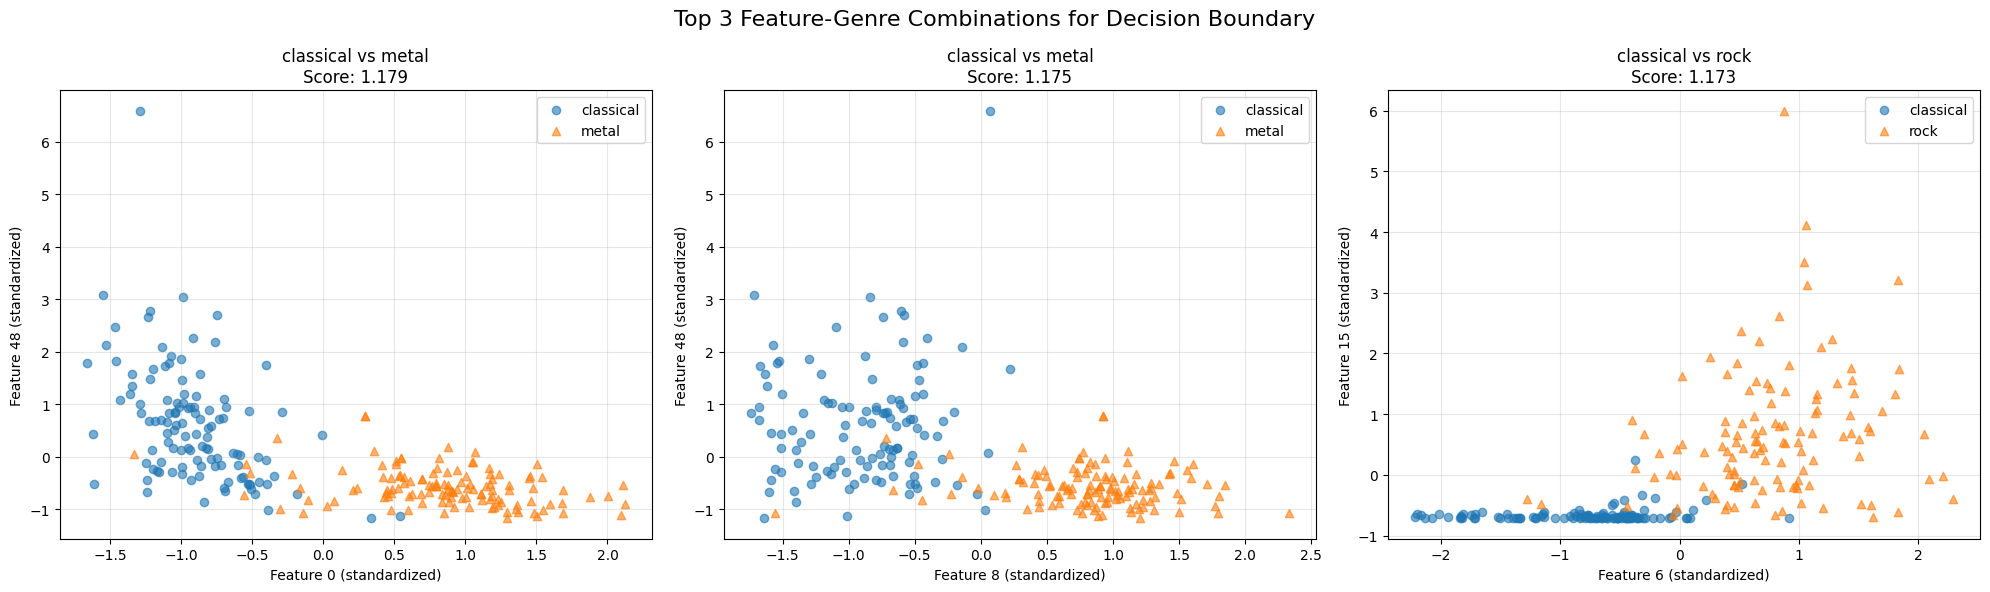


Best combination for decision boundary visualization:
Features: Feature 0 and Feature 48
Genres: classical and metal
Feature indices: 0, 48


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

def analyze_feature_genre_pairs(X_train, y_train, le):
    n_features = X_train.shape[1]
    feature_pairs = list(combinations(range(n_features), 2))
    genre_pairs = list(combinations(np.unique(y_train), 2))

    results = []

    for feat_idx1, feat_idx2 in feature_pairs:
        for genre1_idx, genre2_idx in genre_pairs:
            genre1 = le.inverse_transform([genre1_idx])[0]
            genre2 = le.inverse_transform([genre2_idx])[0]

            mask = np.isin(y_train, [genre1_idx, genre2_idx])
            X_pair = X_train[mask][:, [feat_idx1, feat_idx2]]
            y_pair = y_train[mask]

            if len(X_pair) < 10:
                continue

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_pair)

            means1 = np.mean(X_scaled[y_pair == genre1_idx], axis=0)
            means2 = np.mean(X_scaled[y_pair == genre2_idx], axis=0)
            mean_dist = np.linalg.norm(means1 - means2)

            kurt = np.mean([kurtosis(X_scaled[:, 0]), kurtosis(X_scaled[:, 1])])
            skewness = np.mean([abs(skew(X_scaled[:, 0])), abs(skew(X_scaled[:, 1]))])

            class_balance = min(np.sum(y_pair == genre1_idx),
                              np.sum(y_pair == genre2_idx)) / len(y_pair)

            score = (mean_dist * 0.3 +
                    (1 / (1 + abs(kurt - 3))) * 0.3 +
                    (1 / (1 + abs(skewness - 1))) * 0.2 +
                    class_balance * 0.2)

            results.append({
                'feature1': f'Feature {feat_idx1}',
                'feature2': f'Feature {feat_idx2}',
                'genre1': genre1,
                'genre2': genre2,
                'mean_distance': mean_dist,
                'kurtosis': kurt,
                'skewness': skewness,
                'class_balance': class_balance,
                'score': score,
                'feat_idx1': feat_idx1,
                'feat_idx2': feat_idx2,
                'genre_idx1': genre1_idx,
                'genre_idx2': genre2_idx
            })

    return pd.DataFrame(results)

X_train, X_val, y_train, y_val, le = prepare_data()

results_df = analyze_feature_genre_pairs(X_train, y_train, le)
best_pairs = results_df.nlargest(5, 'score')

print("Top 5 Feature-Genre Combinations:")
print("-" * 80)
for idx, row in best_pairs.iterrows():
    print(f"\nCombination {idx + 1}:")
    print(f"Features: {row['feature1']} vs {row['feature2']}")
    print(f"Genres: {row['genre1']} vs {row['genre2']}")
    print(f"Mean Distance: {row['mean_distance']:.3f}")
    print(f"Kurtosis: {row['kurtosis']:.3f}")
    print(f"Skewness: {row['skewness']:.3f}")
    print(f"Class Balance: {row['class_balance']:.3f}")
    print(f"Overall Score: {row['score']:.3f}")
    print("-" * 80)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top 3 Feature-Genre Combinations for Decision Boundary', fontsize=16)

for idx, (_, row) in enumerate(best_pairs.head(3).iterrows()):
    mask = np.isin(y_train, [row['genre_idx1'], row['genre_idx2']])
    X_pair = X_train[mask][:, [row['feat_idx1'], row['feat_idx2']]]
    y_pair = y_train[mask]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pair)

    axes[idx].scatter(X_scaled[y_pair == row['genre_idx1'], 0],
                     X_scaled[y_pair == row['genre_idx1'], 1],
                     label=row['genre1'], alpha=0.6, marker='o')
    axes[idx].scatter(X_scaled[y_pair == row['genre_idx2'], 0],
                     X_scaled[y_pair == row['genre_idx2'], 1],
                     label=row['genre2'], alpha=0.6, marker='^')

    axes[idx].set_xlabel(f"{row['feature1']} (standardized)")
    axes[idx].set_ylabel(f"{row['feature2']} (standardized)")
    axes[idx].set_title(f"{row['genre1']} vs {row['genre2']}\nScore: {row['score']:.3f}")
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_combo = best_pairs.iloc[0]
print("\nBest combination for decision boundary visualization:")
print(f"Features: {best_combo['feature1']} and {best_combo['feature2']}")
print(f"Genres: {best_combo['genre1']} and {best_combo['genre2']}")
print(f"Feature indices: {best_combo['feat_idx1']}, {best_combo['feat_idx2']}")

Could not convert column data_type. Keeping as is.
Could not convert column genre. Keeping as is.

Classification Metrics:
----------------------------------------
Accuracy: 0.9667
ROC AUC: 0.9666
Precision: 0.9677
Recall: 0.9677
F1 Score: 0.9677

Genre Indices:
----------------------------------------
Classical Index: 0
Metal Index: 3

Class Distribution:
----------------------------------------
Training set:
Classical: 116
Metal: 124

Validation set:
Classical: 29
Metal: 31

Decision Boundary Parameters:
----------------------------------------
Intercept: 0.3725
Coefficient Feature 0: 3.4903
Coefficient Feature 48: -0.7043


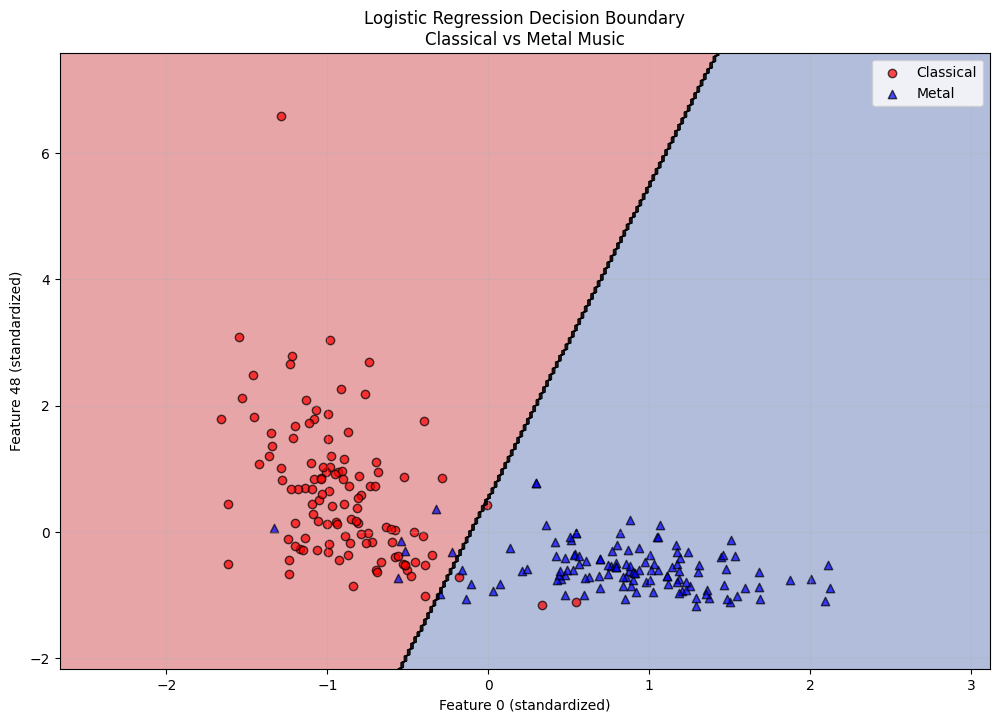

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

X_train, X_val, y_train, y_val, le = prepare_data()

selected_features = [0, 48]
classical_idx = np.where(le.classes_ == 'classical')[0][0]
metal_idx = np.where(le.classes_ == 'metal')[0][0]
selected_genres = [classical_idx, metal_idx]

mask_train = np.isin(y_train, selected_genres)
X_train_binary = X_train[mask_train][:, selected_features]
y_train_binary = y_train[mask_train]

mask_val = np.isin(y_val, selected_genres)
X_val_binary = X_val[mask_val][:, selected_features]
y_val_binary = y_val[mask_val]

scaler = StandardScaler()
X_train_binary_scaled = scaler.fit_transform(X_train_binary)
X_val_binary_scaled = scaler.transform(X_val_binary)

lr = LogisticRegression(random_state=42)
lr.fit(X_train_binary_scaled, y_train_binary)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

plt.figure(figsize=(12, 8))

xx, yy = make_meshgrid(X_train_binary_scaled[:, 0], X_train_binary_scaled[:, 1])
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

classical_mask = y_train_binary == classical_idx
metal_mask = y_train_binary == metal_idx

plt.scatter(X_train_binary_scaled[classical_mask, 0], X_train_binary_scaled[classical_mask, 1],
           label='Classical', marker='o', color='red', edgecolors='black', alpha=0.7)
plt.scatter(X_train_binary_scaled[metal_mask, 0], X_train_binary_scaled[metal_mask, 1],
           label='Metal', marker='^', color='blue', edgecolors='black', alpha=0.7)

plt.xlabel(f'Feature {selected_features[0]} (standardized)')
plt.ylabel(f'Feature {selected_features[1]} (standardized)')
plt.title('Logistic Regression Decision Boundary\nClassical vs Metal Music')
plt.legend()
plt.grid(True, alpha=0.3)

y_pred = lr.predict(X_val_binary_scaled)
y_pred_proba = lr.predict_proba(X_val_binary_scaled)[:, 1]

print("\nClassification Metrics:")
print("-" * 40)
print(f"Accuracy: {accuracy_score(y_val_binary, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_binary, y_pred):.4f}")
print(f"Precision: {precision_score(y_val_binary, y_pred, pos_label=metal_idx):.4f}")
print(f"Recall: {recall_score(y_val_binary, y_pred, pos_label=metal_idx):.4f}")
print(f"F1 Score: {f1_score(y_val_binary, y_pred, pos_label=metal_idx):.4f}")

print("\nGenre Indices:")
print("-" * 40)
print(f"Classical Index: {classical_idx}")
print(f"Metal Index: {metal_idx}")

print("\nClass Distribution:")
print("-" * 40)
print("Training set:")
unique, counts = np.unique(y_train_binary, return_counts=True)
for idx, count in zip(unique, counts):
    genre = 'Classical' if idx == classical_idx else 'Metal'
    print(f"{genre}: {count}")

print("\nValidation set:")
unique, counts = np.unique(y_val_binary, return_counts=True)
for idx, count in zip(unique, counts):
    genre = 'Classical' if idx == classical_idx else 'Metal'
    print(f"{genre}: {count}")

print("\nDecision Boundary Parameters:")
print("-" * 40)
print(f"Intercept: {lr.intercept_[0]:.4f}")
print(f"Coefficient Feature {selected_features[0]}: {lr.coef_[0][0]:.4f}")
print(f"Coefficient Feature {selected_features[1]}: {lr.coef_[0][1]:.4f}")

plt.show()


Support Vectors by Class:
Classical Support Vectors: 16
Metal Support Vectors: 17
Total Support Vectors: 33
Support Vector Ratio: 0.1375

Classification Metrics:
----------------------------------------
Accuracy: 0.9500
ROC AUC: 0.9911
Precision: 0.9667
Recall: 0.9355
F1 Score: 0.9508

Decision Boundary Parameters:
----------------------------------------
Intercept (b): 0.2090
Weight vector (w):
- Feature 0: 2.2690
- Feature 48: -0.1696
||w||: 2.2753
Margin width: 0.8790


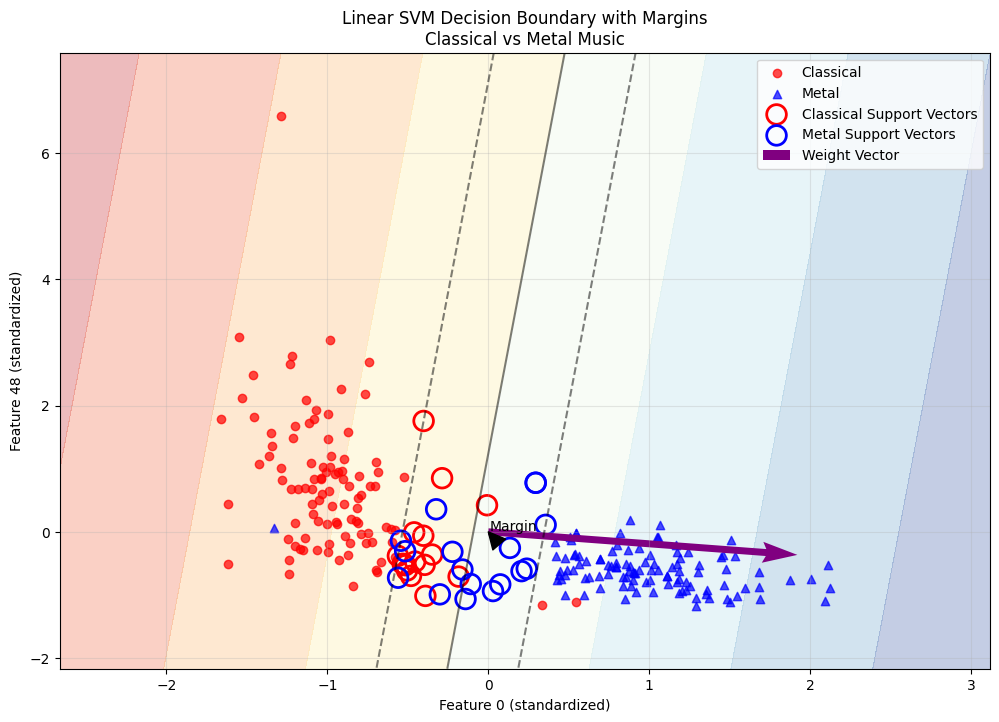

In [ ]:
def plot_margins(svm, X, y):
    plt.figure(figsize=(12, 8))
    w = svm.coef_[0]
    b = svm.intercept_[0]

    xx, yy = make_meshgrid(X[:, 0], X[:, 1])

    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.3)

    decision_values = svm.decision_function(X)
    support_vector_mask = np.abs(decision_values) <= 1.001

    classical_mask = y == classical_idx
    metal_mask = y == metal_idx

    classical_sv_mask = np.logical_and(classical_mask, support_vector_mask)
    metal_sv_mask = np.logical_and(metal_mask, support_vector_mask)

    plt.scatter(X[classical_mask & ~support_vector_mask, 0],
                X[classical_mask & ~support_vector_mask, 1],
                c='red', marker='o', label='Classical', alpha=0.7)
    plt.scatter(X[metal_mask & ~support_vector_mask, 0],
                X[metal_mask & ~support_vector_mask, 1],
                c='blue', marker='^', label='Metal', alpha=0.7)

    plt.scatter(X[classical_sv_mask, 0], X[classical_sv_mask, 1],
                s=200, linewidth=2, facecolors='none', edgecolors='red',
                label='Classical Support Vectors')
    plt.scatter(X[metal_sv_mask, 0], X[metal_sv_mask, 1],
                s=200, linewidth=2, facecolors='none', edgecolors='blue',
                label='Metal Support Vectors')

    origin = np.array([[0, 0]])
    w_direction = w / np.sqrt(np.sum(w**2))
    plt.quiver(origin[0, 0], origin[0, 1], w_direction[0], w_direction[1],
              color='purple', scale=3, label='Weight Vector')

    plt.xlabel(f'Feature {selected_features[0]} (standardized)')
    plt.ylabel(f'Feature {selected_features[1]} (standardized)')
    plt.title('Linear SVM Decision Boundary with Margins\nClassical vs Metal Music')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.annotate('Margin', xy=(0, 0), xytext=(1, 1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                xycoords='data', textcoords='offset points')

    n_classical_sv = np.sum(classical_sv_mask)
    n_metal_sv = np.sum(metal_sv_mask)
    print(f"\nSupport Vectors by Class:")
    print(f"Classical Support Vectors: {n_classical_sv}")
    print(f"Metal Support Vectors: {n_metal_sv}")
    print(f"Total Support Vectors: {n_classical_sv + n_metal_sv}")
    print(f"Support Vector Ratio: {(n_classical_sv + n_metal_sv)/len(X):.4f}")

    return plt

svm = SVC(
    kernel='linear',
    C=1.0,
    probability=True,
    random_state=42
)

svm.fit(X_train_binary_scaled, y_train_binary)

plot_margins(svm, X_train_binary_scaled, y_train_binary)

y_pred = svm.predict(X_val_binary_scaled)
decision_scores = svm.decision_function(X_val_binary_scaled)
y_pred_proba = 1 / (1 + np.exp(-decision_scores))

print("\nClassification Metrics:")
print("-" * 40)
print(f"Accuracy: {accuracy_score(y_val_binary, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val_binary, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_val_binary, y_pred, pos_label=metal_idx):.4f}")
print(f"Recall: {recall_score(y_val_binary, y_pred, pos_label=metal_idx):.4f}")
print(f"F1 Score: {f1_score(y_val_binary, y_pred, pos_label=metal_idx):.4f}")

print("\nDecision Boundary Parameters:")
print("-" * 40)
print(f"Intercept (b): {svm.intercept_[0]:.4f}")
print(f"Weight vector (w):")
print(f"- Feature {selected_features[0]}: {svm.coef_[0][0]:.4f}")
print(f"- Feature {selected_features[1]}: {svm.coef_[0][1]:.4f}")
print(f"||w||: {np.sqrt(np.sum(svm.coef_[0]**2)):.4f}")
print(f"Margin width: {2/np.sqrt(np.sum(svm.coef_[0]**2)):.4f}")

plt.show()

<ipython-input-31-036e9dbf96f6>:28: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z_svm, levels=[0], colors='red', linestyles='-', linewidths=2,
<ipython-input-31-036e9dbf96f6>:30: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z_lr, levels=[0], colors='blue', linestyles='--', linewidths=2,
<ipython-input-31-036e9dbf96f6>:33: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z_svm, levels=[-1, 1], colors='pink', linestyles=':', linewidths=1,



Model Comparison (Training Set):
----------------------------------------
SVM Accuracy: 0.9542
Logistic Regression Accuracy: 0.9583

Angle between decision boundaries: 7.13 degrees


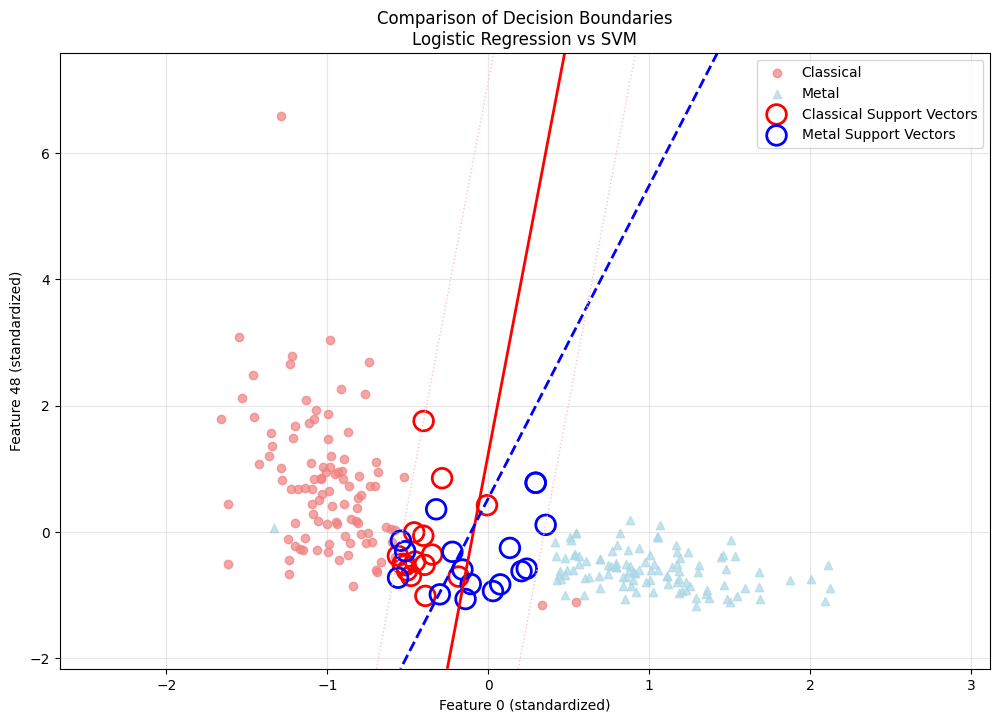

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


def plot_combined_boundaries(X, y, lr_model, svm_model):
    plt.figure(figsize=(12, 8))

    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        return xx, yy

    xx, yy = make_meshgrid(X[:, 0], X[:, 1])

    Z_svm = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_svm = Z_svm.reshape(xx.shape)

    Z_lr = lr_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z_lr = Z_lr.reshape(xx.shape)

    plt.contour(xx, yy, Z_svm, levels=[0], colors='red', linestyles='-', linewidths=2,
                label='SVM Decision Boundary')
    plt.contour(xx, yy, Z_lr, levels=[0], colors='blue', linestyles='--', linewidths=2,
                label='Logistic Regression Decision Boundary')

    plt.contour(xx, yy, Z_svm, levels=[-1, 1], colors='pink', linestyles=':', linewidths=1,
                label='SVM Margins')

    decision_values = svm_model.decision_function(X)
    support_vector_mask = np.abs(decision_values) <= 1.001

    classical_mask = y == classical_idx
    metal_mask = y == metal_idx

    plt.scatter(X[classical_mask & ~support_vector_mask, 0],
                X[classical_mask & ~support_vector_mask, 1],
                c='lightcoral', marker='o', label='Classical', alpha=0.7)
    plt.scatter(X[metal_mask & ~support_vector_mask, 0],
                X[metal_mask & ~support_vector_mask, 1],
                c='lightblue', marker='^', label='Metal', alpha=0.7)

    classical_sv_mask = np.logical_and(classical_mask, support_vector_mask)
    metal_sv_mask = np.logical_and(metal_mask, support_vector_mask)

    plt.scatter(X[classical_sv_mask, 0], X[classical_sv_mask, 1],
                s=200, linewidth=2, facecolors='none', edgecolors='red',
                label='Classical Support Vectors')
    plt.scatter(X[metal_sv_mask, 0], X[metal_sv_mask, 1],
                s=200, linewidth=2, facecolors='none', edgecolors='blue',
                label='Metal Support Vectors')

    plt.xlabel(f'Feature {selected_features[0]} (standardized)')
    plt.ylabel(f'Feature {selected_features[1]} (standardized)')
    plt.title('Comparison of Decision Boundaries\nLogistic Regression vs SVM')
    plt.legend()
    plt.grid(True, alpha=0.3)

    y_pred_svm = svm_model.predict(X)
    y_pred_lr = lr_model.predict(X)

    print("\nModel Comparison (Training Set):")
    print("-" * 40)
    print(f"SVM Accuracy: {accuracy_score(y, y_pred_svm):.4f}")
    print(f"Logistic Regression Accuracy: {accuracy_score(y, y_pred_lr):.4f}")

    w_svm = svm_model.coef_[0]
    w_lr = lr_model.coef_[0]
    angle = np.arccos(np.dot(w_svm, w_lr) /
                     (np.linalg.norm(w_svm) * np.linalg.norm(w_lr)))
    print(f"\nAngle between decision boundaries: {np.degrees(angle):.2f} degrees")

    return plt

plot_combined_boundaries(X_train_binary_scaled, y_train_binary, lr, svm)
plt.show()